In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix, roc_auc_score, classification_report

Index(['ApplicationDate', 'Age', 'AnnualIncome', 'CreditScore',
       'EmploymentStatus', 'EducationLevel', 'Experience', 'LoanAmount',
       'LoanDuration', 'MaritalStatus', 'NumberOfDependents',
       'HomeOwnershipStatus', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'LoanPurpose', 'PreviousLoanDefaults', 'PaymentHistory',
       'LengthOfCreditHistory', 'SavingsAccountBalance',
       'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities',
       'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'NetWorth',
       'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment',
       'TotalDebtToIncomeRatio', 'LoanApproved', 'RiskScore'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------              

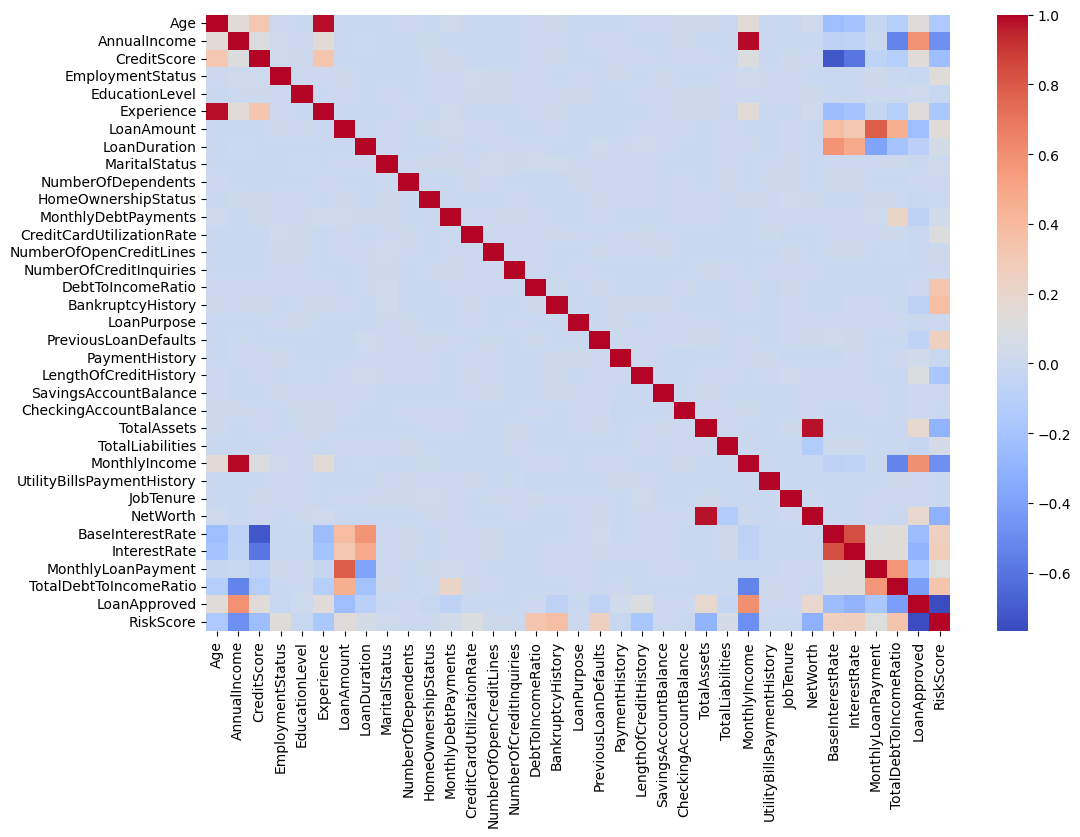

In [ ]:
# Dataset location : "https://www.kaggle.com/datasets/lorenzozoppelletto/financial-risk-for-loan-approval"
df = pd.read_csv('loan.csv')
print(df.columns)
print(df.info())

# Drop ApplicationDate due to insignificant effect
df.drop('ApplicationDate', axis = 1, inplace = True)

# transform some features from dtype object to numerical for modelling purposes
df['EmploymentStatus'] = LabelEncoder().fit_transform(df['EmploymentStatus'])
df['EducationLevel'] = LabelEncoder().fit_transform(df['EducationLevel'])
df['MaritalStatus'] = LabelEncoder().fit_transform(df['MaritalStatus'])
df['HomeOwnershipStatus'] = LabelEncoder().fit_transform(df['HomeOwnershipStatus'])
df['LoanPurpose'] = LabelEncoder().fit_transform(df['LoanPurpose'])

# correlation matrix
# figure 1 in the final report
plt.figure(figsize = (12,8))
sns.heatmap(df.corr(), cmap = 'coolwarm')
plt.show()

#### 1. Binary Classification

In [ ]:
# set some options for parameters in models
n = [5, 10, 15] # n_neighbors in KNeighbors Classifier
num = [100, 200, 300] # n_estimator in RandomForest and Gradient Boosting
depth = [10, 20, None] # max_depth in Random Forest
C = [0.1, 1, 5, 10] # C in SVC
learn_rate = [0.05, 0.1, 0.5, 1] # learning_rate in Gradient Boosting

In [ ]:
# Learning curve KNN
# Data is non-negative, some are categories, some are numeric data
# Suitable for chi-square test
def learning_curve(x, y, n, cv):
    score = []
    for i in range(34,1,-1):
        x_chi = SelectKBest(chi2, k = i).fit_transform(x , y)
        knn = KNeighborsClassifier(n_neighbors = n)
        CV_score = cross_val_score(knn, x_chi, y, cv = cv).mean() 
        # mean() to return the average CV_score of 5-folds (cv = 5)       
        score.append(CV_score)

    plt.plot(range(34,1,-1), score, linewidth = 1.5, color = "blue", alpha = 0.8)
    plt.title("Learning curve KNN", fontsize = 14)
    plt.xlabel("Number of features", fontsize = 10)
    plt.ylabel("Cross-Validation Score", fontsize = 10)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

In [4]:
y_approved = df['LoanApproved']
x_approved = df.drop("LoanApproved", axis = 1)

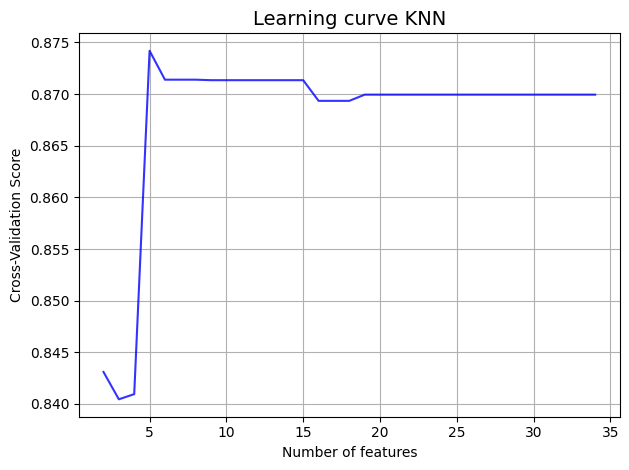

In [5]:
learning_curve(x_approved, y_approved, n = 10, cv = 5)

In [6]:
chi_value, p_value_chi = chi2(x_approved, y_approved)

# features have p-value less than 5% indicate significant
x_approved = x_approved[x_approved.columns[p_value_chi <= 0.05]]
print(f'{(p_value_chi <= 0.05).sum()} features have p-value <= 5%')
print(x_approved.columns)

# preprocessing data
x_scaled = StandardScaler().fit_transform(x_approved)
x_pca = PCA(n_components = 0.95).fit_transform(x_scaled)
print(f"number of features after PCA: {x_pca.shape[1]}") 
# reduce from 25 features to 17 features

25 features have p-value <= 5%
Index(['Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus',
       'EducationLevel', 'Experience', 'LoanAmount', 'LoanDuration',
       'HomeOwnershipStatus', 'MonthlyDebtPayments', 'BankruptcyHistory',
       'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets',
       'TotalLiabilities', 'MonthlyIncome', 'NetWorth', 'BaseInterestRate',
       'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio',
       'RiskScore'],
      dtype='object')
number of features after PCA: 17


In [ ]:
# allocate training and testing sets
# random_state = 42
x_train, x_test, y_train, y_test = train_test_split(x_pca, y_approved, test_size = 0.25, random_state = 42)

# compare different models
for i in n:
    model = KNeighborsClassifier(n_neighbors = i).fit(x_train, y_train)
    print(f"KNN model accuracy with n = {i}:")
    print(f"    In train set:{accuracy_score(y_train, model.predict(x_train)) : .6f}")
    print(f"    In test set:{accuracy_score(y_test, model.predict(x_test)) : .6f}")
  
# n_estimators (default = 100) 
# max_depth (default = None) 
# high n_estimators and max_depth can achieve higher accuracy on training set
# risk of over-fitting
for k in num:
    for d in depth:
        rf_mod = RandomForestClassifier(random_state = 42, n_estimators = k,
                                        max_depth = d).fit(x_train, y_train)
        print(f"RandomForest model accuracy with {k} estimators and depth = {d}:") 
        print(f"    In train set:{accuracy_score(y_train, rf_mod.predict(x_train)) : .6f}")
        print(f"    In test set:{accuracy_score(y_test, rf_mod.predict(x_test)) : .6f}")

# kernel = rbf : non-linear and non-polynomial relationships
# C (default = 1) : high C can achieve higher accuracy on training set
# risk of over-fitting
for c in C:
    svm = SVC(kernel = "rbf", C = c, random_state = 42).fit(x_train, y_train)
    print(f"SVC model accuracy with C = {c}:")
    print(f"    In train set:{accuracy_score(y_train, svm.predict(x_train)) : .6f}")
    print(f"    In test set:{accuracy_score(y_test, svm.predict(x_test)) : .6f}") 

KNN model accuracy with n = 5:
    In train set: 0.966067
    In test set: 0.949000
KNN model accuracy with n = 10:
    In train set: 0.955067
    In test set: 0.945400
KNN model accuracy with n = 15:
    In train set: 0.958067
    In test set: 0.955600
RandomForest model accuracy with 100 estimators and depth = 10:
    In train set: 0.987400
    In test set: 0.958600
RandomForest model accuracy with 100 estimators and depth = 20:
    In train set: 1.000000
    In test set: 0.963600
RandomForest model accuracy with 100 estimators and depth = None:
    In train set: 1.000000
    In test set: 0.962600
RandomForest model accuracy with 200 estimators and depth = 10:
    In train set: 0.987733
    In test set: 0.959400
RandomForest model accuracy with 200 estimators and depth = 20:
    In train set: 1.000000
    In test set: 0.965000
RandomForest model accuracy with 200 estimators and depth = None:
    In train set: 1.000000
    In test set: 0.964200
RandomForest model accuracy with 300 est

In [24]:
# random_state = 2024
x_train, x_test, y_train, y_test = train_test_split(x_pca, y_approved, test_size = 0.25, random_state = 2024)
for i in n:
    model = KNeighborsClassifier(n_neighbors = i).fit(x_train, y_train)
    print(f"KNN model accuracy with n = {i}:")
    print(f"    In train set:{accuracy_score(y_train, model.predict(x_train)) : .6f}")
    print(f"    In test set:{accuracy_score(y_test, model.predict(x_test)) : .6f}")

for k in num:
    for d in depth:
        rf_mod = RandomForestClassifier(random_state = 2024, n_estimators = k,
                                        max_depth = d).fit(x_train, y_train)
        print(f"RandomForest model accuracy with {k} estimators and depth = {d}:") 
        print(f"    In train set:{accuracy_score(y_train, rf_mod.predict(x_train)) : .6f}")
        print(f"    In test set:{accuracy_score(y_test, rf_mod.predict(x_test)) : .6f}")

for c in C:
    svm = SVC(kernel = "rbf", C = c, random_state = 2024).fit(x_train, y_train)
    print(f"SVC model accuracy with C = {c}:")
    print(f"    In train set:{accuracy_score(y_train, svm.predict(x_train)) : .6f}")
    print(f"    In test set:{accuracy_score(y_test, svm.predict(x_test)) : .6f}") 

KNN model accuracy with n = 5:
    In train set: 0.967733
    In test set: 0.945200
KNN model accuracy with n = 10:
    In train set: 0.956467
    In test set: 0.947800
KNN model accuracy with n = 15:
    In train set: 0.958800
    In test set: 0.953800
RandomForest model accuracy with 100 estimators and depth = 10:
    In train set: 0.987667
    In test set: 0.960800
RandomForest model accuracy with 100 estimators and depth = 20:
    In train set: 1.000000
    In test set: 0.963600
RandomForest model accuracy with 100 estimators and depth = None:
    In train set: 1.000000
    In test set: 0.964000
RandomForest model accuracy with 200 estimators and depth = 10:
    In train set: 0.987267
    In test set: 0.960400
RandomForest model accuracy with 200 estimators and depth = 20:
    In train set: 1.000000
    In test set: 0.964800
RandomForest model accuracy with 200 estimators and depth = None:
    In train set: 1.000000
    In test set: 0.964600
RandomForest model accuracy with 300 est

In [ ]:
# random_state = 123
x_train, x_test, y_train, y_test = train_test_split(x_pca, y_approved, test_size = 0.25, random_state = 123)
for i in n:
    model = KNeighborsClassifier(n_neighbors = i).fit(x_train, y_train)
    print(f"KNN model accuracy with n = {i}:")
    print(f"    In train set:{accuracy_score(y_train, model.predict(x_train)) : .6f}")
    print(f"    In test set:{accuracy_score(y_test, model.predict(x_test)) : .6f}")

for k in num:
    for d in depth:
        rf_mod = RandomForestClassifier(random_state = 123, n_estimators = k,
                                        max_depth = d).fit(x_train, y_train)
        print(f"RandomForest model accuracy with {k} estimators and depth = {d}:")
        print(f"    In train set:{accuracy_score(y_train, rf_mod.predict(x_train)) : .6f}")
        print(f"    In test set:{accuracy_score(y_test, rf_mod.predict(x_test)) : .6f}")

for c in C:
    svm = SVC(kernel = "rbf", C = c, random_state = 123).fit(x_train, y_train)
    print(f"SVC model accuracy with C = {c}:")
    print(f"    In train set:{accuracy_score(y_train, svm.predict(x_train)) : .6f}")
    print(f"    In test set:{accuracy_score(y_test, svm.predict(x_test)) : .6f}") 

KNN model accuracy with n = 5:
    In train set: 0.968933
    In test set: 0.942600
KNN model accuracy with n = 10:
    In train set: 0.956467
    In test set: 0.939000
KNN model accuracy with n = 15:
    In train set: 0.959600
    In test set: 0.944400
RandomForest model accuracy with 100 estimators and depth = 10:
    In train set: 0.986867
    In test set: 0.951400
RandomForest model accuracy with 100 estimators and depth = 20:
    In train set: 1.000000
    In test set: 0.958600
RandomForest model accuracy with 100 estimators and depth = None:
    In train set: 1.000000
    In test set: 0.959200
RandomForest model accuracy with 200 estimators and depth = 10:
    In train set: 0.987467
    In test set: 0.952400
RandomForest model accuracy with 200 estimators and depth = 20:
    In train set: 1.000000
    In test set: 0.958200
RandomForest model accuracy with 200 estimators and depth = None:
    In train set: 1.000000
    In test set: 0.958800
RandomForest model accuracy with 300 est

In [ ]:
def plot_confusion_matrix(ytest, ypred, LABELS):
    plt.figure(figsize = (4, 4))
    sns.heatmap(confusion_matrix(ytest, ypred), 
                annot = True,
                xticklabels = LABELS,
                yticklabels = LABELS, 
                annot_kws = {"size":10},
                fmt = "d", cmap = "YlGnBu")
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.title("Confusion matrix", fontdict = {"size" : 14})
    plt.xlabel('True', fontdict = {"size" : 12})
    plt.ylabel('Predicted', fontdict = {"size" : 12})
    plt.tight_layout()
    plt.show()

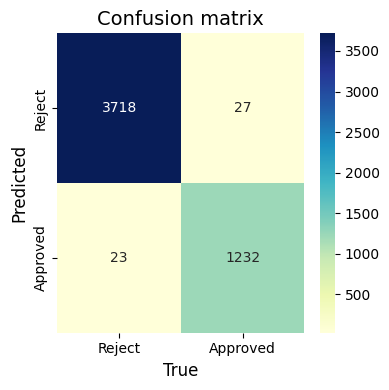

In [ ]:
# figure 3 in the final report
labels = ['Reject', 'Approved']
plot_confusion_matrix(y_test, svm.predict(x_test), labels)
# fmt = "d" : integer (.2f : float - g : optional)

#### 2. Score card model

In [ ]:
# use Loan Approved as target variable
# some pairs of features exhibit high correlation
x_risk = x_approved.drop(['Experience','MonthlyIncome','NetWorth',
                'BaseInterestRate','MonthlyLoanPayment'], axis = 1)

# allocate training and testing sets
x_tr_risk, x_test_risk, y_tr_risk, y_test_risk = train_test_split(x_risk, y_approved, test_size = 0.25, random_state = 42)

# tranform data use Logistic Regression
# solver = saga: well-suited for large datasets and 
# performs efficiently on sparse matrices
# encoding categorical variables leading to many zero values in the features
risk_mod = LogisticRegression(max_iter = 5000, random_state = 42, solver = 'saga').fit(x_tr_risk, y_tr_risk)

print(f"Logistic Regression model auc_score :")
print(f"    In train set:{roc_auc_score(y_tr_risk, risk_mod.predict_proba(x_tr_risk)[:, -1]) : .6f}")
print(f"    In test set:{roc_auc_score(y_test_risk, risk_mod.predict_proba(x_test_risk)[:, -1]) : .6f}")

# table 2 in the final report
print(f"Classification Report :")
print(f"    In train set:\n {classification_report(y_tr_risk, risk_mod.predict(x_tr_risk))}")
print(f"    In test set:\n {classification_report(y_test_risk, risk_mod.predict(x_test_risk))}")

Logistic Regression model auc_score :
    In train set: 0.924426
    In test set: 0.925278
Classification Report :
    In train set:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     11475
           1       0.76      0.70      0.73      3525

    accuracy                           0.88     15000
   macro avg       0.83      0.82      0.82     15000
weighted avg       0.87      0.88      0.88     15000

    In test set:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92      3745
           1       0.79      0.70      0.75      1255

    accuracy                           0.88      5000
   macro avg       0.85      0.82      0.83      5000
weighted avg       0.88      0.88      0.88      5000



c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [20]:
# random_state = 2024
x_tr_risk, x_test_risk, y_tr_risk, y_test_risk = train_test_split(x_risk, y_approved, test_size = 0.25, random_state = 2024)
risk_mod = LogisticRegression(max_iter = 5000, random_state = 2024, solver = 'saga').fit(x_tr_risk, y_tr_risk)

print(f"Logistic Regression model auc_score :")
print(f"    In train set:{roc_auc_score(y_tr_risk, risk_mod.predict_proba(x_tr_risk)[:, -1]) : .6f}")
print(f"    In test set:{roc_auc_score(y_test_risk, risk_mod.predict_proba(x_test_risk)[:, -1]) : .6f}")

print(f"Classification Report :")
print(f"    In train set:\n {classification_report(y_tr_risk, risk_mod.predict(x_tr_risk))}")
print(f"    In test set:\n {classification_report(y_test_risk, risk_mod.predict(x_test_risk))}")

Logistic Regression model auc_score :
    In train set: 0.925729
    In test set: 0.923661
Classification Report :
    In train set:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     11406
           1       0.76      0.71      0.73      3594

    accuracy                           0.88     15000
   macro avg       0.84      0.82      0.83     15000
weighted avg       0.87      0.88      0.88     15000

    In test set:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      3814
           1       0.75      0.71      0.73      1186

    accuracy                           0.88      5000
   macro avg       0.83      0.82      0.82      5000
weighted avg       0.87      0.88      0.87      5000



c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# random_state = 12345
x_tr_risk, x_test_risk, y_tr_risk, y_test_risk = train_test_split(x_risk, y_approved, test_size = 0.25, random_state = 12345)
risk_mod = LogisticRegression(max_iter = 5000, random_state = 12345, solver = 'saga').fit(x_tr_risk, y_tr_risk)

print(f"Logistic Regression model auc_score :")
print(f"    In train set:{roc_auc_score(y_tr_risk, risk_mod.predict_proba(x_tr_risk)[:, -1]) : .6f}")
print(f"    In test set:{roc_auc_score(y_test_risk, risk_mod.predict_proba(x_test_risk)[:, -1]) : .6f}")

print(f"Classification Report :")
print(f"    In train set:\n {classification_report(y_tr_risk, risk_mod.predict(x_tr_risk))}")
print(f"    In test set:\n {classification_report(y_test_risk, risk_mod.predict(x_test_risk))}")

Logistic Regression model auc_score :
    In train set: 0.920697
    In test set: 0.927394
Classification Report :
    In train set:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     11453
           1       0.75      0.70      0.72      3547

    accuracy                           0.87     15000
   macro avg       0.83      0.81      0.82     15000
weighted avg       0.87      0.87      0.87     15000

    In test set:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      3767
           1       0.78      0.71      0.75      1233

    accuracy                           0.88      5000
   macro avg       0.85      0.82      0.83      5000
weighted avg       0.88      0.88      0.88      5000



c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


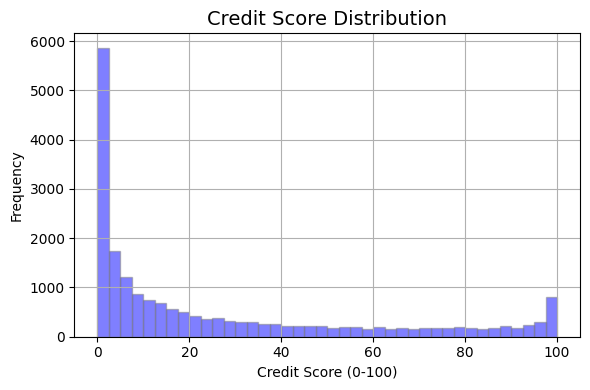

In [ ]:
# credit score = probability prediction * 100
credit_score = risk_mod.predict_proba(x_risk)[:,-1] * 100

# plot the prediction results
# figure 4 in the final report
plt.figure(figsize = (6, 4))
plt.hist(credit_score, bins = 40, alpha = 0.5, color = 'blue', edgecolor = "gray")
plt.title('Credit Score Distribution', fontdict = {"size" : 14})
plt.xlabel('Credit Score (0-100)')
plt.ylabel('Frequency')
plt.grid()
plt.tight_layout()
plt.show()

#### 3. Default Risk Prediction

In [ ]:
y_def = df['PreviousLoanDefaults']
x_def = df.drop("PreviousLoanDefaults", axis = 1)

# features have p-value less than 5% indicate significant
chi_val_def, p_val_chi_def = chi2(x_def, y_def)
x_def = x_def[x_def.columns[p_val_chi_def <= 0.05]]
print(f'{(p_val_chi_def <= 0.05).sum()} features have p-value <= 5%')
print(x_def.columns)

# preprocessing data
x_def_scaled = StandardScaler().fit_transform(x_def)
x_def_pca = PCA(n_components = 0.95).fit_transform(x_def_scaled)
print(f"number of features after PCA: {x_def_pca.shape[1]}") 
# reduce from 14 features to 10 features

14 features have p-value <= 5%
Index(['AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration',
       'MonthlyDebtPayments', 'SavingsAccountBalance',
       'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities',
       'MonthlyIncome', 'NetWorth', 'MonthlyLoanPayment', 'LoanApproved',
       'RiskScore'],
      dtype='object')
number of features after PCA: 10


In [ ]:
# allocate training and testing sets
# random_state = 42
x_tr, x_te, y_tr, y_te = train_test_split(x_def_pca, y_def, test_size = 0.25, random_state = 42)

for i in n:
    knn_mod = KNeighborsClassifier(n_neighbors = i).fit(x_tr, y_tr)
    print(f"KNN model accuracy with n = {i}:")
    print(f"    In train set:{accuracy_score(y_tr, knn_mod.predict(x_tr)) : .6f}")
    print(f"    In test set:{accuracy_score(y_te, knn_mod.predict(x_te)) : .6f}")

# different models as GradientBoostingClassifier and RandomForestClassifier
# results is not improved
for r in learn_rate:
    for k in num:
        GBC_model = GradientBoostingClassifier(random_state = 42, n_estimators = k,
                                               learning_rate = r).fit(x_tr, y_tr)
        print(f"GBC model accuracy with {k} estimators and learning_rate = {r}:")
        print(f"    In train set:{accuracy_score(y_tr, GBC_model.predict(x_tr)) : .6f}")
        print(f"    In test set:{accuracy_score(y_te, GBC_model.predict(x_te)) : .6f}")

for k in num:
    RFC_model = RandomForestClassifier(random_state = 42, n_estimators = k).fit(x_tr, y_tr)
    print(f"RandomForest model accuracy with {k} estimators:")
    print(f"    In train set:{accuracy_score(y_tr, RFC_model.predict(x_tr)) : .6f}")
    print(f"    In test set:{accuracy_score(y_te, RFC_model.predict(x_te)) : .6f}")

KNN model accuracy with n = 5:
    In train set: 0.909133
    In test set: 0.894200
KNN model accuracy with n = 10:
    In train set: 0.901467
    In test set: 0.900000
KNN model accuracy with n = 15:
    In train set: 0.900533
    In test set: 0.900800
GBC model accuracy with 100 estimators and learning_rate = 0.05:
    In train set: 0.901200
    In test set: 0.899800
GBC model accuracy with 200 estimators and learning_rate = 0.05:
    In train set: 0.903400
    In test set: 0.898200
GBC model accuracy with 300 estimators and learning_rate = 0.05:
    In train set: 0.905333
    In test set: 0.896400
GBC model accuracy with 100 estimators and learning_rate = 0.1:
    In train set: 0.903800
    In test set: 0.897200
GBC model accuracy with 200 estimators and learning_rate = 0.1:
    In train set: 0.909200
    In test set: 0.894800
GBC model accuracy with 300 estimators and learning_rate = 0.1:
    In train set: 0.913000
    In test set: 0.895400
GBC model accuracy with 100 estimators an

In [ ]:
# random_state = 2024
x_tr, x_te, y_tr, y_te = train_test_split(x_def_pca, y_def, test_size = 0.25, random_state = 2024)

for i in n:
    knn_mod = KNeighborsClassifier(n_neighbors = i).fit(x_tr, y_tr)
    print(f"KNN model accuracy with n = {i}:")
    print(f"    In train set:{accuracy_score(y_tr, knn_mod.predict(x_tr)) : .6f}")
    print(f"    In test set:{accuracy_score(y_te, knn_mod.predict(x_te)) : .6f}")

# different models as GradientBoostingClassifier and RandomForestClassifier
# results is not improved
# learning_rate and max_depth should be balance
for r in learn_rate:
    for k in num:
        GBC_model = GradientBoostingClassifier(random_state = 2024, n_estimators = k,
                                               learning_rate = r).fit(x_tr, y_tr)
        print(f"GBC model accuracy with {k} estimators and learning_rate = {r}:")
        print(f"    In train set:{accuracy_score(y_tr, GBC_model.predict(x_tr)) : .6f}")
        print(f"    In test set:{accuracy_score(y_te, GBC_model.predict(x_te)) : .6f}")

for k in num:
    RFC_model = RandomForestClassifier(random_state = 2024, n_estimators = k).fit(x_tr, y_tr)
    print(f"RandomForest model accuracy with {k} estimators:")
    print(f"    In train set:{accuracy_score(y_tr, RFC_model.predict(x_tr)) : .6f}")
    print(f"    In test set:{accuracy_score(y_te, RFC_model.predict(x_te)) : .6f}")
# random forest models has accuracy in the training sets close to 100% 
# suggest over-fitting

KNN model accuracy with n = 5:
    In train set: 0.909733
    In test set: 0.887600
KNN model accuracy with n = 10:
    In train set: 0.902200
    In test set: 0.896000
KNN model accuracy with n = 15:
    In train set: 0.901267
    In test set: 0.895000
GBC model accuracy with 100 estimators and learning_rate = 0.05:
    In train set: 0.901200
    In test set: 0.894800
GBC model accuracy with 200 estimators and learning_rate = 0.05:
    In train set: 0.903400
    In test set: 0.893200
GBC model accuracy with 300 estimators and learning_rate = 0.05:
    In train set: 0.906467
    In test set: 0.893400
GBC model accuracy with 100 estimators and learning_rate = 0.1:
    In train set: 0.904200
    In test set: 0.892800
GBC model accuracy with 200 estimators and learning_rate = 0.1:
    In train set: 0.909267
    In test set: 0.892000
GBC model accuracy with 300 estimators and learning_rate = 0.1:
    In train set: 0.913933
    In test set: 0.893000
GBC model accuracy with 100 estimators an

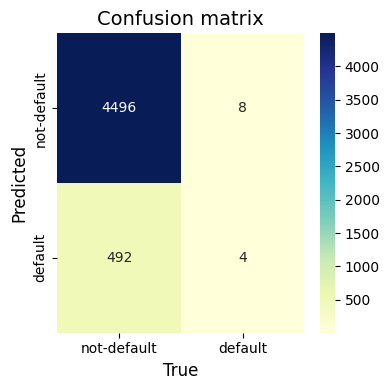

In [ ]:
# figure 5 in the final report
label = ['not-default', 'default']
plot_confusion_matrix(y_te, knn_mod.predict(x_te), label)
# since there are too little default history in the dataset
# difficult for model to recognize potential default

In [26]:
total_def = sum(df['PreviousLoanDefaults'] != 0)
print(total_def)
total_def/ df.shape[0]

2001


0.10005

#### 4. Credit Line Prediction

In [ ]:
y_lim = df['LoanAmount']
x_lim = df.drop("LoanAmount", axis = 1)

chi_val_lim, p_val_chi_lim = chi2(x_lim, y_lim)

# features have p-value less than 5% indicate significant
x_lim = x_lim[x_lim.columns[p_val_chi_lim <= 0.05]]
print(f'{(p_val_chi_lim <= 0.05).sum()} features have p-value <= 5%')
print(x_lim.columns)

19 features have p-value <= 5%
Index(['Age', 'AnnualIncome', 'CreditScore', 'EmploymentStatus',
       'EducationLevel', 'Experience', 'LoanDuration', 'NumberOfDependents',
       'HomeOwnershipStatus', 'MonthlyDebtPayments', 'LengthOfCreditHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets',
       'TotalLiabilities', 'MonthlyIncome', 'NetWorth', 'MonthlyLoanPayment',
       'RiskScore'],
      dtype='object')


In [ ]:
# allocate training and testing sets
# random_state = 42
x_lim_tr, x_lim_te, y_lim_tr, y_lim_te = train_test_split(x_lim, y_lim, test_size = 0.25, random_state = 42)
mod_lim = LinearRegression().fit(x_lim_tr, y_lim_tr)
print(f"linear model R2_score : {r2_score(y_lim_te, mod_lim.predict(x_lim_te)) : .6f}")
# as expected, linear regression explain model poorly

for r in learn_rate:
    GBR_mod = GradientBoostingRegressor(learning_rate = r, random_state = 42).fit(x_lim_tr, y_lim_tr)
    print(f"GBR model R2_score with learning_rate = {r}:")
    print(f"    In train set:{r2_score(y_lim_tr, GBR_mod.predict(x_lim_tr)) : .6f}")
    print(f"    In test set:{r2_score(y_lim_te, GBR_mod.predict(x_lim_te)) : .6f}")

for d in depth:
    RFR_lim = RandomForestRegressor(random_state = 42, max_depth = d).fit(x_lim_tr, y_lim_tr)
    print(f"Random Forest model R2_score with depth = {d}:")
    print(f"    In train set: {r2_score(y_lim_tr, RFR_lim.predict(x_lim_tr)) : .6f}")
    print(f"    In test set: {r2_score(y_lim_te, RFR_lim.predict(x_lim_te)) : .6f}")

linear model R2_score :  0.728955
GBR model R2_score with learning_rate = 0.05:
    In train set: 0.983303
    In test set: 0.982800
GBR model R2_score with learning_rate = 0.1:
    In train set: 0.991046
    In test set: 0.989163
GBR model R2_score with learning_rate = 0.5:
    In train set: 0.991298
    In test set: 0.987344
GBR model R2_score with learning_rate = 1:
    In train set: 0.992377
    In test set: 0.986166
Random Forest model R2_score with depth = 10:
    In train set:  0.993960
    In test set:  0.987258
Random Forest model R2_score with depth = 20:
    In train set:  0.997945
    In test set:  0.987414
Random Forest model R2_score with depth = None:
    In train set:  0.997939
    In test set:  0.987394


In [15]:
# random_state = 2024
x_lim_tr, x_lim_te, y_lim_tr, y_lim_te = train_test_split(x_lim, y_lim, test_size = 0.25, random_state = 2024)
mod_lim = LinearRegression().fit(x_lim_tr, y_lim_tr)
print(f"linear model R2_score : {r2_score(y_lim_te, mod_lim.predict(x_lim_te)) : .6f}")

for r in learn_rate:
    GBR_mod = GradientBoostingRegressor(learning_rate = r, random_state = 2024).fit(x_lim_tr, y_lim_tr)
    print(f"GBR model R2_score with learning_rate = {r}:")
    print(f"    In train set:{r2_score(y_lim_tr, GBR_mod.predict(x_lim_tr)) : .6f}")
    print(f"    In test set:{r2_score(y_lim_te, GBR_mod.predict(x_lim_te)) : .6f}")

for k in num:
    RFR_lim_lim = RandomForestRegressor(random_state = 2024, n_estimators = k).fit(x_lim_tr, y_lim_tr)
    print(f"Random Forest model R2_score with {k} estimators:")
    print(f"    In train set: {r2_score(y_lim_tr, RFR_lim.predict(x_lim_tr)) : .6f}")
    print(f"    In test set: {r2_score(y_lim_te, RFR_lim.predict(x_lim_te)) : .6f}")

linear model R2_score :  0.704961
GBR model R2_score with learning_rate = 0.05:
    In train set: 0.983707
    In test set: 0.981771
GBR model R2_score with learning_rate = 0.1:
    In train set: 0.991296
    In test set: 0.988760
GBR model R2_score with learning_rate = 0.5:
    In train set: 0.991760
    In test set: 0.986676
GBR model R2_score with learning_rate = 1:
    In train set: 0.992099
    In test set: 0.984781
Random Forest model R2_score with 100 estimators:
    In train set:  0.995370
    In test set:  0.995806
Random Forest model R2_score with 200 estimators:
    In train set:  0.995370
    In test set:  0.995806
Random Forest model R2_score with 300 estimators:
    In train set:  0.995370
    In test set:  0.995806


In [21]:
# random_state = 123
x_lim_tr, x_lim_te, y_lim_tr, y_lim_te = train_test_split(x_lim, y_lim, test_size = 0.25, random_state = 123)
mod_lim = LinearRegression().fit(x_lim_tr, y_lim_tr)
print(f"linear model R2_score : {r2_score(y_lim_te, mod_lim.predict(x_lim_te)) : .6f}")

for r in learn_rate:
    GBR_mod = GradientBoostingRegressor(learning_rate = r, random_state = 123).fit(x_lim_tr, y_lim_tr)
    print(f"GBR model R2_score with learning_rate = {r}:")
    print(f"    In train set:{r2_score(y_lim_tr, GBR_mod.predict(x_lim_tr)) : .6f}")
    print(f"    In test set:{r2_score(y_lim_te, GBR_mod.predict(x_lim_te)) : .6f}")

for d in depth:
    RFR_lim = RandomForestRegressor(random_state = 123, max_depth = d).fit(x_lim_tr, y_lim_tr)
    print(f"Random Forest model R2_score with depth = {d}:")
    print(f"    In train set: {r2_score(y_lim_tr, RFR_lim.predict(x_lim_tr)) : .6f}")
    print(f"    In test set: {r2_score(y_lim_te, RFR_lim.predict(x_lim_te)) : .6f}")

linear model R2_score :  0.713807
GBR model R2_score with learning_rate = 0.05:
    In train set: 0.983881
    In test set: 0.971540
GBR model R2_score with learning_rate = 0.1:
    In train set: 0.990919
    In test set: 0.980481
GBR model R2_score with learning_rate = 0.5:
    In train set: 0.991364
    In test set: 0.981797
GBR model R2_score with learning_rate = 1:
    In train set: 0.990426
    In test set: 0.971426
Random Forest model R2_score with depth = 10:
    In train set:  0.994104
    In test set:  0.977741
Random Forest model R2_score with depth = 20:
    In train set:  0.998192
    In test set:  0.978432
Random Forest model R2_score with depth = None:
    In train set:  0.998195
    In test set:  0.977638


In [ ]:
# random_state = 1000
x_lim_tr, x_lim_te, y_lim_tr, y_lim_te = train_test_split(x_lim, y_lim, test_size = 0.25, random_state = 1000)
mod_lim = LinearRegression().fit(x_lim_tr, y_lim_tr)
print(f"linear model R2_score : {r2_score(y_lim_te, mod_lim.predict(x_lim_te)) : .6f}")

for r in learn_rate:
    GBR_mod = GradientBoostingRegressor(learning_rate = r, random_state = 1000).fit(x_lim_tr, y_lim_tr)
    print(f"GBR model R2_score with learning_rate = {r}:")
    print(f"    In train set:{r2_score(y_lim_tr, GBR_mod.predict(x_lim_tr)) : .6f}")
    print(f"    In test set:{r2_score(y_lim_te, GBR_mod.predict(x_lim_te)) : .6f}")

for k in num:
    RFR_lim = RandomForestRegressor(random_state = 1000, n_estimators = k).fit(x_lim_tr, y_lim_tr)
    print(f"Random Forest model R2_score with {k} estimators:")
    print(f"    In train set: {r2_score(y_lim_tr, RFR_lim.predict(x_lim_tr)) : .6f}")
    print(f"    In test set: {r2_score(y_lim_te, RFR_lim.predict(x_lim_te)) : .6f}")

linear model R2_score :  0.711295
GBR model R2_score with learning_rate = 0.05:
    In train set: 0.983793
    In test set: 0.972716
GBR model R2_score with learning_rate = 0.1:
    In train set: 0.991206
    In test set: 0.981909
GBR model R2_score with learning_rate = 0.5:
    In train set: 0.991292
    In test set: 0.982217
GBR model R2_score with learning_rate = 1:
    In train set: 0.990654
    In test set: 0.980036
Random Forest model R2_score with 100 estimators:
    In train set:  0.998242
    In test set:  0.980526
Random Forest model R2_score with 200 estimators:
    In train set:  0.998297
    In test set:  0.980589
Random Forest model R2_score with 300 estimators:
    In train set:  0.998318
    In test set:  0.980616


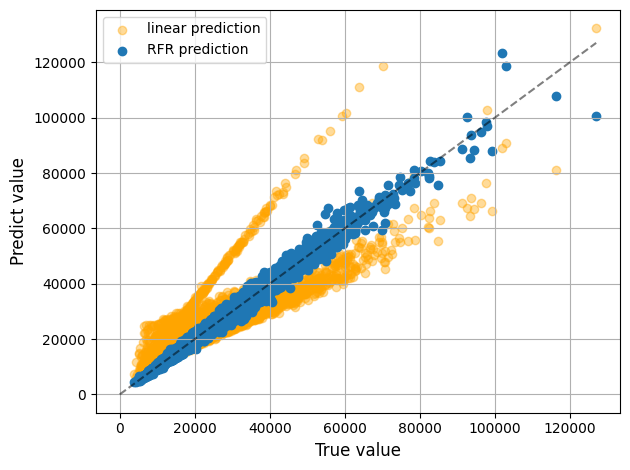

In [ ]:
# figure 6 in the final report
n = round(max(y_lim_te))
plt.scatter(y_lim_te, mod_lim.predict(x_lim_te), color = "orange", 
            alpha = 0.4, label = "linear prediction")
plt.scatter(y_lim_te, RFR_lim.predict(x_lim_te), label = "RFR prediction")
plt.plot(range(n), range(n),
         linestyle = "--", 
         color = "black", alpha = 0.5)
plt.xlabel("True value", fontdict = {"size" : 12 })
plt.ylabel("Predict value", fontdict = {"size" : 12 })
plt.legend(loc = 'upper left')
plt.grid()
plt.tight_layout()
plt.show()

# even predict values != true values
# predict values are not deviate too much from true values 
# can be used to approximate loan amount